In [1]:
import os, pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Data Preprocessing Pipeline for Predictive Quality Control of Solar Power Systems

In [2]:
##encode values
def data_pipe(
            data_path = 'data/Predictive_Quality_Control.xlsx',
            class_dict = {
                        "Solar Panel output": 0,
                        "Charge Controller to battery": 1,
                        "Charge Controller to inverter": 2,
                        "Battery output": 3
                    }):
    df = pd.read_excel(data_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    ##Replaces the string values with corresponding numeric values 
    df['power_output_type'] = df['power_output_type'].apply(lambda x: class_dict[x])
    df = df.sort_values(by='DateTime')
    del df['DateTime']
    df = df.dropna()
    
    X = df.drop('power_output (W)', axis=1)
    Y = df['power_output (W)']

    return X, Y

#### Train-Test Split for Solar Power Output Prediction

In [3]:
##Calling the data_pipe() Function
X, Y = data_pipe()
##Splitting the Dataset into Training and Testing Sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size=0.2, 
                                                random_state=42
                                                )

print(f"Xtrain shape: {Xtrain.shape}")
print(f"Ytrain shape: {Ytrain.shape}")
print(f"Xtest shape: {Xtest.shape}")
print(f"Ytest shape: {Ytest.shape}")

Xtrain shape: (921, 7)
Ytrain shape: (921,)
Xtest shape: (231, 7)
Ytest shape: (231,)


In [4]:
cat = CatBoostRegressor(
                        n_estimators=20,
                        max_depth=12
                        )
cat.fit(X, Y)

Learning rate set to 0.5
0:	learn: 371.5244668	total: 308ms	remaining: 5.85s
1:	learn: 352.0021354	total: 456ms	remaining: 4.1s
2:	learn: 327.2674062	total: 603ms	remaining: 3.42s
3:	learn: 307.8949059	total: 792ms	remaining: 3.17s
4:	learn: 289.1700207	total: 1.02s	remaining: 3.06s
5:	learn: 271.2979305	total: 1.16s	remaining: 2.71s
6:	learn: 257.1765296	total: 1.3s	remaining: 2.42s
7:	learn: 244.3646296	total: 1.46s	remaining: 2.19s
8:	learn: 233.7453371	total: 1.62s	remaining: 1.98s
9:	learn: 220.7229990	total: 1.77s	remaining: 1.77s
10:	learn: 208.7338275	total: 1.92s	remaining: 1.57s
11:	learn: 197.5767719	total: 2.07s	remaining: 1.38s
12:	learn: 190.1595704	total: 2.21s	remaining: 1.19s
13:	learn: 181.3978028	total: 2.34s	remaining: 1s
14:	learn: 174.1509056	total: 2.48s	remaining: 827ms
15:	learn: 166.9800448	total: 2.62s	remaining: 656ms
16:	learn: 159.5448105	total: 2.76s	remaining: 488ms
17:	learn: 149.3953598	total: 2.9s	remaining: 322ms
18:	learn: 146.0684427	total: 3.04s	r

In [5]:
## Saving the Trained Model for Predictive Quality Control
with open('artifacts/quality_control.pickle', 'wb') as f:
    pickle.dump(cat, f)

In [6]:
## Model Prediction on Training and Test Data
Ptrain = cat.predict(Xtrain)
Ptest = cat.predict(Xtest)

#### Evaluation Metrics for Model Performance

In [7]:
mse = mean_squared_error(Ytest, Ptest)
mae = mean_absolute_error(Ytest, Ptest)
r2 = r2_score(Ytest, Ptest)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 19912.45896929279
Mean Absolute Error: 115.9678201474305
R2 Score: 0.876368000791645


### Visualization: Ground Truth vs Predicted Power Output

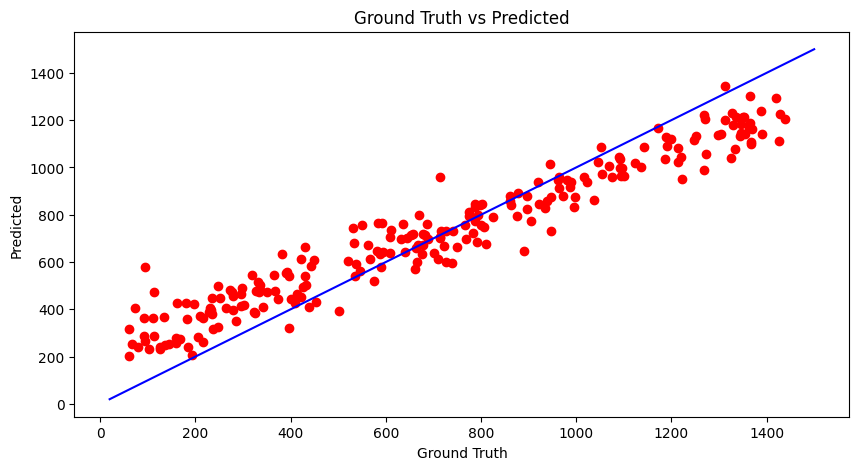

In [8]:
plt.figure(figsize=(10, 5))
plt.scatter(Ytest, Ptest, color='red')
plt.plot([20, 1500], [20, 1500], color='blue')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.title('Ground Truth vs Predicted')
plt.show()

### inference

In [9]:
## Loading the Saved Model for Predictive Quality Control
with open('artifacts/quality_control.pickle', 'rb') as f:
    cat = pickle.load(f)

#### Inference Function for Predictive Power Quality Control

In [10]:
## real-time inference on the power output quality
def inference_quality(
                    json_data,
                    class_dict = {
                                "Solar Panel output": 0,
                                "Charge Controller to battery": 1,
                                "Charge Controller to inverter": 2,
                                "Battery output": 3
                                },
                    power_range_dict = {
                                    "components": {
                                        "Solar Panel output": {
                                            "lower_bound": 250,
                                            "upper_bound": 400
                                        },
                                        "Charge Controller to battery": {
                                            "lower_bound": 150,
                                            "upper_bound": 300
                                        },
                                        "Charge Controller to inverter": {
                                            "lower_bound": 200,
                                            "upper_bound": 350
                                        },
                                        "Battery output": {
                                            "lower_bound": 200,
                                            "upper_bound": 400
                                        }
                                    }
                                }
                    ):
    df = pd.DataFrame([json_data])
    details = power_range_dict['components'][json_data['power_output_type']]
    df['power_output_type'] = df['power_output_type'].apply(lambda x: class_dict[x])
    pred = cat.predict(df)
    power = int(pred.squeeze())
    lower_bound = details['lower_bound']
    upper_bound = details['upper_bound']

    if power < lower_bound:
        status = "Power level is too low"
    elif power > upper_bound:
        status = "Power level is too high"
    else:
        status = "Power level is within range"
    power = f"{power} W"
    return {
        "power": power,
        "status": status
        }

In [11]:
sample_json = {
            "ambient_temperature (°C)" : 40.24,
            "irradiance (W/m²)" : 200.36,
            "humidity (%)" : 75.76,
            "device_temperature (°C)" : 45.93,
            "output_current (A)" : 15.80,
            "output_voltage (V)" : 409.46,
            "power_output (W)" : 1377.75,
            "power_output_type" : "Battery output"
            }

In [12]:
inference_quality(sample_json)

{'power': '847 W', 'status': 'Power level is too high'}